In [7]:
from datetime import datetime as dt
from preprocessing import Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, RocCurveDisplay
from imblearn.over_sampling import RandomOverSampler

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")
    

tensor([1.], device='mps:0')


In [4]:
def plot_history(history, metric='accuracy'):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    
    plt.plot(history.history['loss'], 'b', label='Training loss')
    plt.plot(history.history['val_loss'], 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history[metric], 'b', label='Training accuracy')
    plt.plot(history.history[f'val_{metric}'],'r', label='Validation accuracy')
    plt.title('Training and validation auc')
    plt.legend()

# Preprocessing

In [5]:
col_drop = ['CustomerId','Surname']
types = {
    'HasCrCard':bool,
    'IsActiveMember':bool
}
train = pd.read_csv('data/train.csv', index_col='id', dtype=types).drop(columns=col_drop)
test = pd.read_csv('data/test.csv', index_col='id', dtype=types).drop(columns=col_drop)

In [6]:
train.shape

(165034, 11)

In [7]:
X = train.drop(columns='Exited')
y = train.Exited

In [8]:
y.value_counts(True)

Exited
0    0.788401
1    0.211599
Name: proportion, dtype: float64

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

In [10]:
y_train.shape

(123775,)

In [11]:
y_train.value_counts(True)

Exited
0    0.788398
1    0.211602
Name: proportion, dtype: float64

In [12]:
ros = RandomOverSampler(random_state=42)
#X_train, y_train = ros.fit_resample(X_train, y_train)

In [13]:
y_train.shape

(123775,)

In [14]:
y_train.value_counts(True)

Exited
0    0.788398
1    0.211602
Name: proportion, dtype: float64

In [15]:
prepro = Preprocessing()

In [16]:
X_train_scld = prepro.fit_transform(X_train).astype(float)
X_test_scld = prepro.transform(X_test).astype(float)

In [17]:
X_train_scld

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,
63806,-1.517552,0.0,1.0,0.008476,0.7,-0.915543,0.333333,0.0,1.0,-1.987961
29783,0.756177,0.0,0.0,0.008476,0.5,-0.915543,0.000000,1.0,1.0,0.657130
8017,0.956065,0.0,1.0,-0.114702,0.2,-0.915543,0.000000,1.0,1.0,-1.245744
51414,0.643740,0.0,1.0,-0.114702,0.6,1.110301,0.000000,1.0,1.0,1.431748
103027,0.468838,0.0,0.0,-0.242223,0.2,1.114410,0.000000,0.0,1.0,-0.721095
...,...,...,...,...,...,...,...,...,...,...
87099,-0.430659,0.0,1.0,-2.036501,0.4,-0.915543,0.333333,0.0,0.0,-1.343312
85783,1.268391,0.0,1.0,0.768249,0.9,-0.915543,0.000000,1.0,0.0,-0.516755
8922,-0.155813,0.0,1.0,0.127567,0.6,1.095110,0.000000,1.0,1.0,1.064312


# Model

In [18]:
X_train_scld.shape

(123775, 10)

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [ ]:
# Fonction de perte pondérée pour classes déséquilibrées
def weighted_binary_cross_entropy(output, target, weights=None):
    if weights is not None:
        assert len(weights) == 2

        loss = weights[1] * (target * torch.log(output + 1e-10)) + \
               weights[0] * ((1 - target) * torch.log(1 - output + 1e-10))
    else:
        loss = target * torch.log(output + 1e-10) + (1 - target) * torch.log(1 - output + 1e-10)

    return torch.neg(torch.mean(loss))

In [ ]:
input_size = # Taille de votre vecteur d'entrée
hidden_size1 = 32
hidden_size2 = 16
output_size = 1
model = SimpleNN(input_size, hidden_size1, hidden_size2, output_size)
weights = [0.2, 0.8]  # À ajuster selon le déséquilibre de vos classes
criterion = weighted_binary_cross_entropy
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Paramètres du modèle
  # Pour une classification binaire

# Création du modèle


# Définition de la fonction de perte pondérée


# Optimiseur


# Entraînement du modèle avec vos données
# Assurez-vous de prétraiter vos données et de les convertir en tensors PyTorch avant de les utiliser
# DataLoader peut être utilisé pour gérer les batches de données

# Exemple de DataLoader
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Boucle d'entraînement


# Une fois que le modèle est entraîné, vous pouvez l'utiliser pour effectuer des prédictions.
# Assurez-vous de convertir vos données de test en tensors PyTorch et de les passer à travers le modèle.


In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels, weights)
        loss.backward()
        optimizer.step()

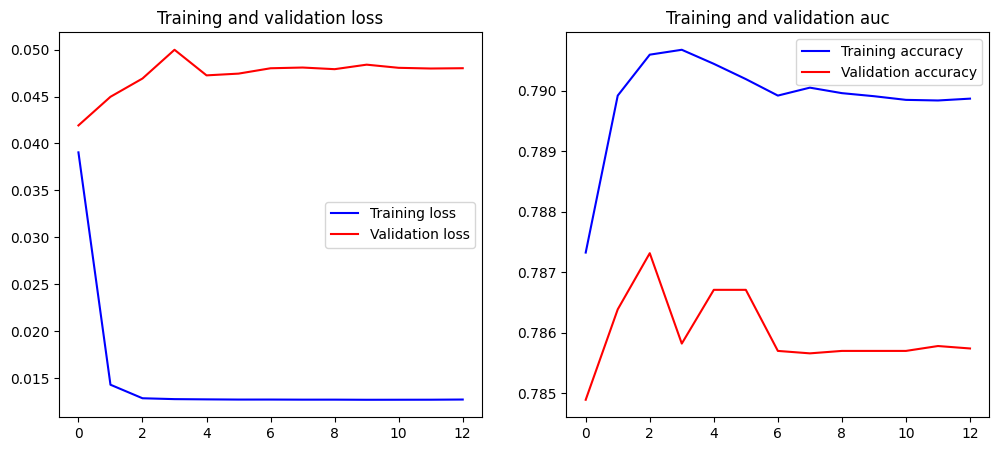

In [20]:
plot_history(history, 'accuracy')

# Score

In [21]:
pred = model.predict(X_test_scld.values)

1290/1290 [==============================] - 2s 2ms/step


In [36]:
RocScore  = roc_auc_score(y_test, pred[:,0])
print(f'Roc Auc Score : {RocScore:.6f}')

Roc Auc Score : 0.814817


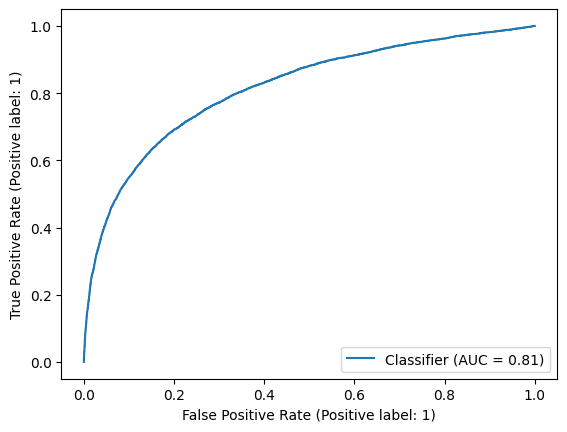

In [86]:
RocCurveDisplay.from_predictions(y_test,pred[:,0])

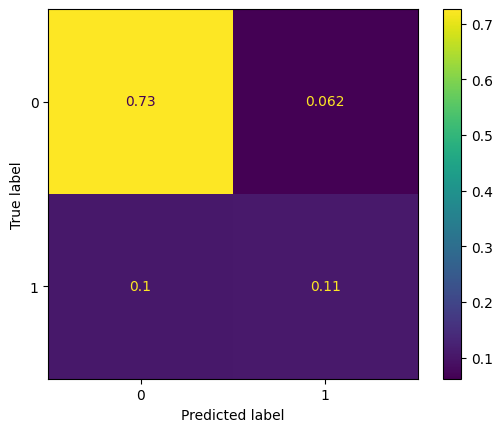

In [79]:
ConfusionMatrixDisplay(confusion_matrix(y_test,pred[:,0]>0.5, normalize='all')).plot()

# Submission

In [ ]:
X_val_scld = prepro.transform(test)

In [ ]:
submission = pd.read_csv("data/sample_submission.csv", index_col='id')

In [ ]:
submission.loc[:,'Exited'] = nn.predict_proba(X_val_scld)[:,1]

/Users/marc/Library/Mobile Documents/com~apple~CloudDocs/Projects/Playground/playgroundseries_s4e1/.venv/lib/python3.10/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


In [ ]:
submission

,Exited
id,
165034,0.085936
165035,0.947197
165036,0.079534
165037,0.519489
165038,0.638603
...,...
275052,0.132850
275053,0.217605
275054,0.071276


In [ ]:
name = dt.now().strftime("%Y%m%d_%H%M")

In [ ]:
#submission.to_csv(f"submission/{name}.csv")